# Arima 7:3

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.0 MB/s eta 0:00:00


In [2]:
# Thư viện
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Đọc file
df = pd.read_excel('eth_processed_data.xlsx')

In [4]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1914,2024-05-27,3826.127197,3973.556396,3821.930420,3892.006836,3892.006836,18949181813
1915,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
1916,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
1917,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797


In [6]:
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra(7:3)
# Kích thước tập dữ liệu "Close"(7:3)
train_size = int(0.7*len(time_series_Close))
# Giá trị tập từ liệu "Close" (7:3)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:]
# Lấy index (7:3)
index_train_data = train_data.index
index_test_data = test_data.index
last_index = index_test_data.max()

In [ ]:
auto_arima(train_data, start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=9.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16746.309, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16310.009, Time=2.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=16741.604, Time=0.44 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16152.605, Time=4.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=21.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16157.839, Time=1.60 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=16153.737, Time=3.07 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=17.77 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=16152.996, Time=3.77 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=16155.381, Time=5.59 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=16154.602, Time=9.66 sec

Best model:  ARIMA(1,1,0)(2,1,0)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [7]:
# Huấn luyện model
model = ARIMA(train_data, order=(1,1,0))
fit_model= model.fit()
# Prediction trên tập kiểm tra
predictions = fit_model.predict(start=test_data.index[0], end=test_data.index[-1] )
# Dự đoán 30/60/90
forecast_90 = fit_model.forecast(steps=90)

In [8]:
# Đưa dựa đoán vào index
time_series_Close_90 = df['Close'].copy()
time_series_Close_90 = pd.concat([time_series_Close_90, forecast_90])
forecast_90 = time_series_Close_90.iloc[-90:]
forecast_90.index = range(last_index+1, last_index+91)
forecast_90

1919    1523.950339
1920    1523.650882
1921    1523.672039
1922    1523.670544
1923    1523.670650
           ...     
2004    1523.670643
2005    1523.670643
2006    1523.670643
2007    1523.670643
2008    1523.670643
Length: 90, dtype: float64

In [9]:
# Xác định kích thước mỗi phần
split_size = len(forecast_90) // 3
forecast_values_30day = forecast_90[:split_size]
forecast_values_60day = forecast_90[split_size:2*split_size]
forecast_values_90day = forecast_90[2*split_size:]

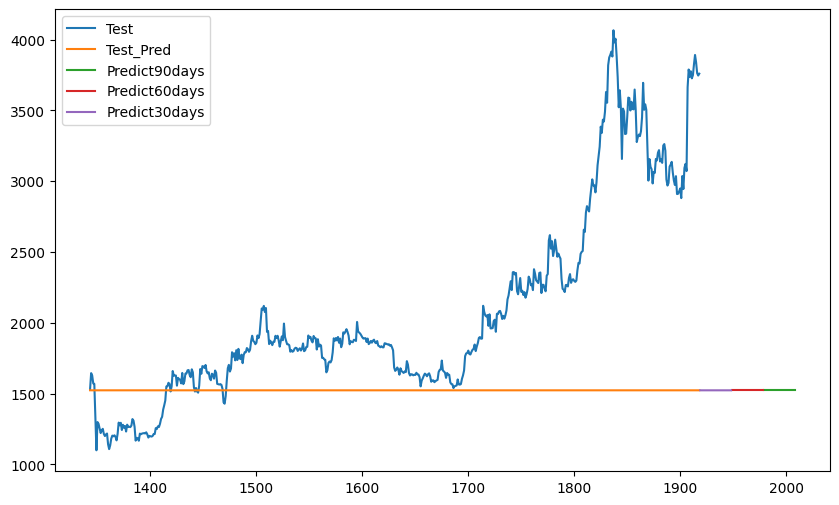

In [10]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
plt.plot(test_data.index,test_data, label='Test')
plt.plot( predictions, label='Test_Pred')
plt.plot(forecast_values_90day.index, forecast_values_90day,label='Predict90days')
plt.plot(forecast_values_60day.index, forecast_values_60day,label='Predict60days')
plt.plot(forecast_values_30day.index, forecast_values_30day, label='Predict30days')
plt.legend()
plt.show()

In [11]:
# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
# Tính toán MAE
mae = mean_absolute_error(test_data, predictions)
# Tính toán MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_data, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 884.4924794164293
MAE: 617.8966262924761
MAPE: 24.824001068946433
